# tSNE visualisation of gene profile clustering

Results from different clustering algorithms used on gene expression profiles data visualised on tSNE embedding. Gene profile is regarded as all measurments across all replicates.

### Load data

In [34]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt

from correlation_enrichment.library import SimilarityCalculator
from library_regulons import *

plt.rcParams["figure.figsize"] = (12,8)

In [2]:
dataPath=module_path+'/data_expression/'
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)
neighbour_calculator = NeighbourCalculator(genes,conditions=conditions,conditions_names_column='Measurment')

### Obtain genes with close neighbours and prepare data for clustering and tSNE

Genes with at least one neighbour with profile similarity above 0.99 (cosine) are obtained. As genes may have similar profile but different expression range their profiles are preprocessed to remove effects of expression strength in cosine distance/similarity calculation. Each gene profile is preprocessed with log transformation and scaling from 0 to 1. These distanes/similarities are used for clustering and tSNE. Distances are computed as 1-similarity.

In [3]:
inverse=False # Similar profile (e.g. not similar inversed profile)
threshold=0.99 # Cosine similarity threshold for obtaining genes with at least one close neighbour
neighbours_result = neighbour_calculator.neighbours(n_neighbours=2, inverse=inverse) # 2 neighbours as the closest neighbour is often self
distance_matrix,gene_names,genes_pp=Clustering.get_clustering_data(neighbours_result, genes, threshold=threshold, 
                                                                    inverse=inverse)
# Preprocessing of data from all genes is done on data from NeigbbouRCalculator, 
# as it remouves genes with all 0 expression
genes_all_pp=NeighbourCalculator.get_index_query(genes=neighbour_calculator._genes,inverse=inverse)[0]

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../orange3venv/lib/python3.6/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


### tSNE embedding

Below is prepared tSNE embedding for: 1.) all genes and 2.) genes selected for regulon calculation. tSNE is performed on scaled data, as described in 'Obtain genes with close neighbours and prepare data for clustering and tSNE'. Multiscale was used in tSNE to better preserve global structure.

In [4]:
embedding_all=make_tsne(genes_all_pp, perplexities_range= [5, 100], exaggerations = [17, 1.6],
              momentums = [0.6, 0.97])

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../orange3venv/lib/python3.6/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [5]:
embedding=make_tsne(genes_pp, perplexities_range= [5, 100], exaggerations = [17, 1.6],
              momentums = [0.6, 0.97])

/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "


## tSNE of all genes and genes selected for regulon claculation

The below plot shows tSNE on scaled expression data of all genes. Selected genes (which have at least one very close neighbour and will be used for regulon calculation) are marked with 'selected', others with 'NaN'. 

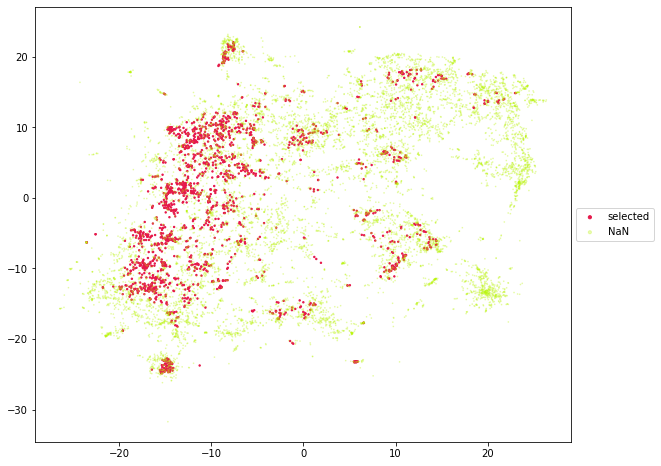

In [37]:
classes=dict(zip(gene_names,['selected']*len(gene_names)))
plot_tsne(embedding_all, classes=classes, names=neighbour_calculator._genes.index, legend=True,
          plotting_params={'selected':{'s':2},'NaN':{'s':0.5,'alpha':0.3}})

There is evident separation of tSNE plot on half with many genes with at least one very close neighbour (e.g. selected) and genes that do not have extremely close neighbours (based on expression pattern). It is possible that this could be explained by the following: When selected genes were previously compared with clusters of differentially expressed genes (DE, for each mutant strain against AX4 in individual time points) most of them were located in clusters that did not show DE or showed DE pattern through time that indicated expression before differentiation (shown below). It is possible that selected genes contain more housekeeping genes (expressed regardless of differentiation, e.g. ribosomal genes, etc.) which are more tightly regulated, thus having more close neighbours. Alternatively, it is possible that they are genes expressed in all strains, thus reducing the chance that they would have low expression profile sections in some strains, which could be more inclined to random variation (both due to biological and technical reasons). However, this would require further testing.

Clusters of DE genes (showing DE genes in mutant strains in time points (top) compared to genes in AX4 (bottom)):
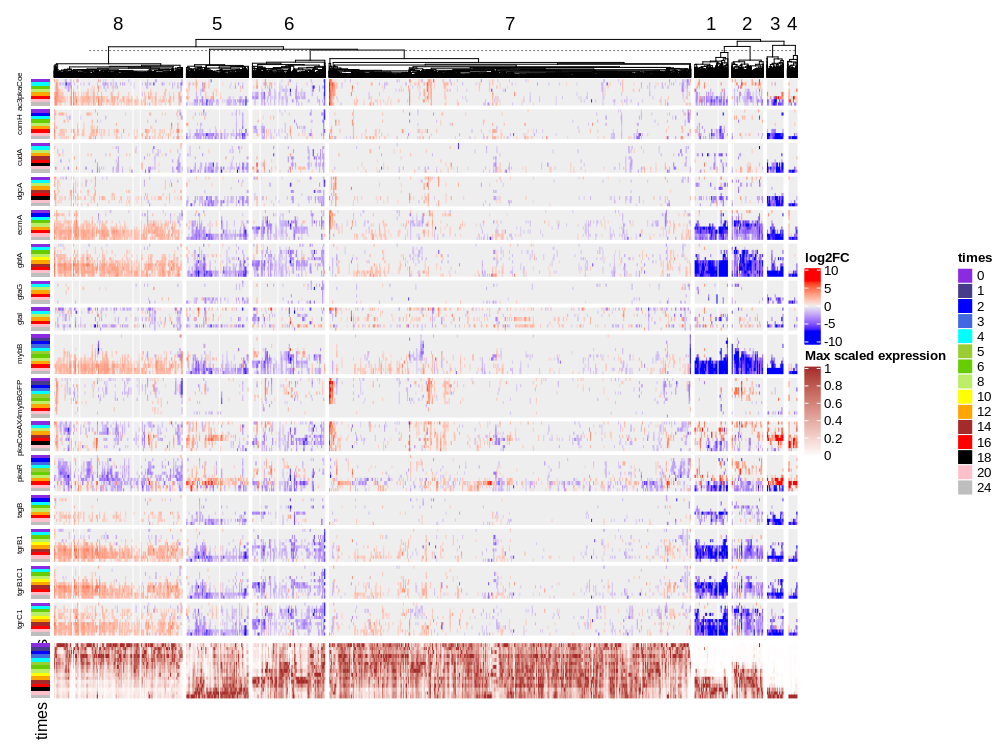
Cluster memebership distribution for all genes:
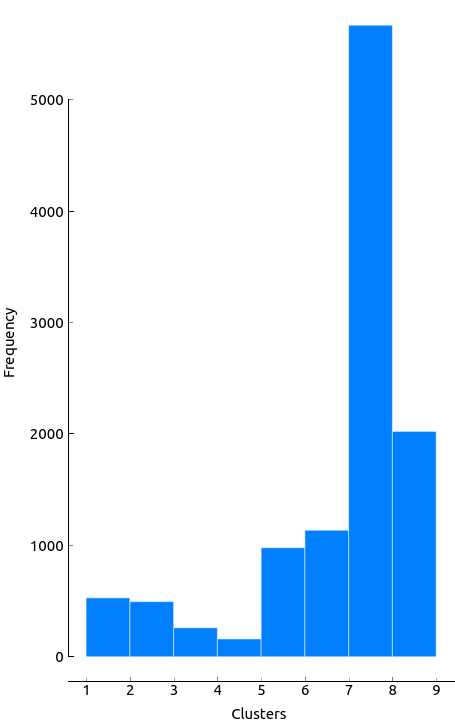
Cluster membership dictribution for selected genes:
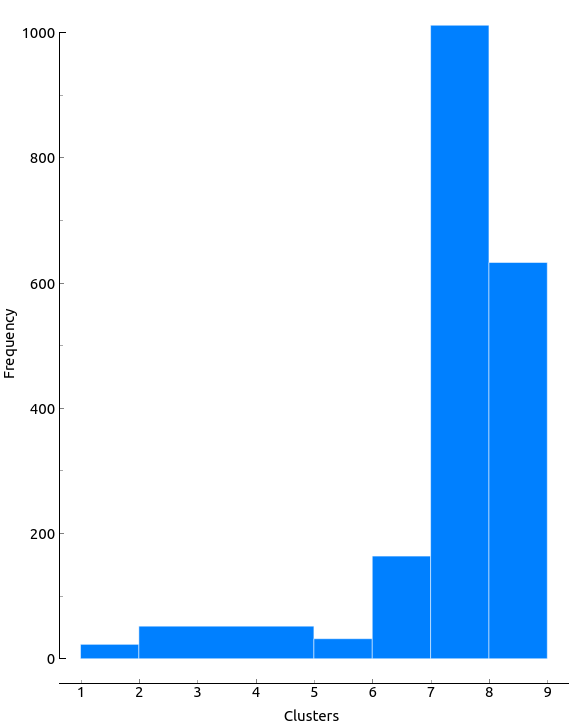

## tSNE visualisations for clustering algoritms

Different clustering algoritms were implemented to find the one that best correcponds with tSNE visualisation based on expression data from genes selected for regulon calculation. For each algorithm a single clustering is shown. Clustering that seems to correspond best with tSNE was selected. Except where stated elsehow, clusterings are based on cosine distances between scaled expression profiles of selected genes.

### Hierarchical clustering

In [25]:
hierarchical=HierarchicalClustering(distance_matrix=distance_matrix,gene_names=gene_names,data=genes_pp)

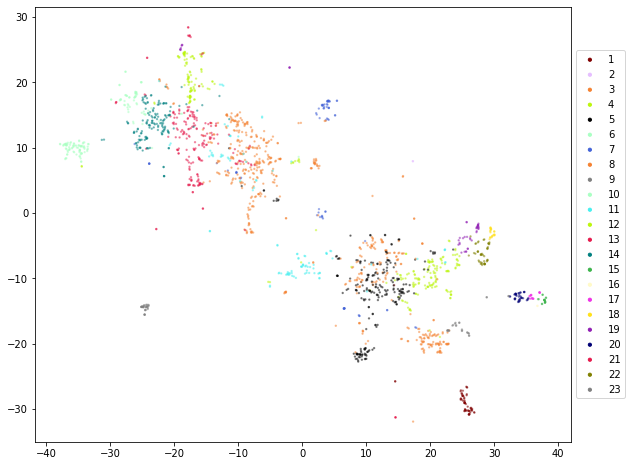

In [60]:
plot_tsne(embedding,classes=hierarchical.get_clusters_by_genes({'t':0.19}),names=gene_names,legend=True,
          plotting_params={'s':2,'alpha':0.4})

### DBSCAN

None of the clusterings (with different parameters)  performed well.

In [61]:
dbscan=DBSCANClustering(distance_matrix=distance_matrix,gene_names=gene_names,data=genes_pp)

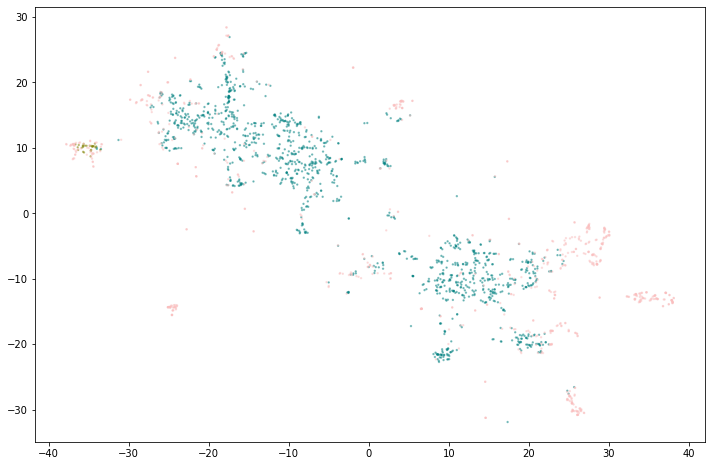

In [85]:
plot_tsne(embedding,classes=dbscan.get_clusters_by_genes({'eps':0.01,'min_samples':30}),
          names=gene_names,legend=False,
          plotting_params={'s':2,'alpha':0.4})

### Gaussian mixture fitting-based clustering

Here clustering is not based on cosine distances but on preprocessed expression data, which was used for model fitting.

In [86]:
gaussian=GaussianMixtureClustering(distance_matrix=distance_matrix,gene_names=gene_names,data=genes_pp)

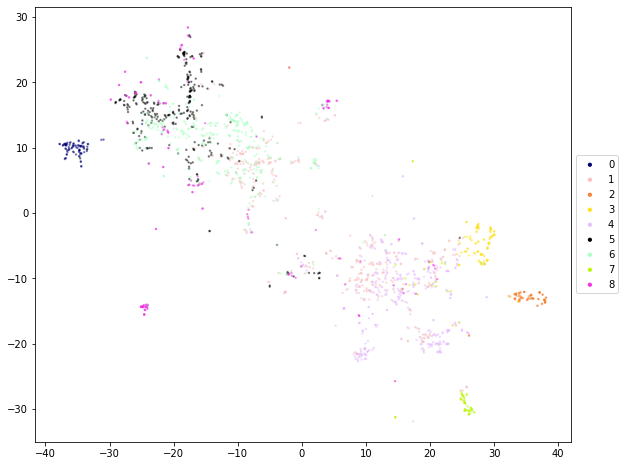

In [98]:
plot_tsne(embedding,classes=gaussian.get_clusters_by_genes({'n_components':9}),
          names=gene_names,legend=True,
          plotting_params={'s':2,'alpha':0.4})

### Louvain

Louvain must be performed on graph. To do this 3 different graph constructions were performed: 
1. edges based on cosine similarity, retaining only edges with weight equal or greater than threshold,
2. edges based on cosine similarity, retaining N best edges (neighbours) for each node,
3. using graph construction from Orange, where N closest neighbours are computed for each node and edge weight is based on the number of shared neighbours between nodes (Jaccard index).

#### Option 1: edges based on cosine similarity, retaining only edges with weight equal or greater than threshold

In [126]:
louvain1=LouvainClustering(distance_matrix=distance_matrix, gene_names=gene_names, data=genes_pp, 
                                    orange_graph=False,trimm = 0.98)

In [127]:
louvain_clustering1=louvain1.get_clusters_by_genes({'resolution':1})

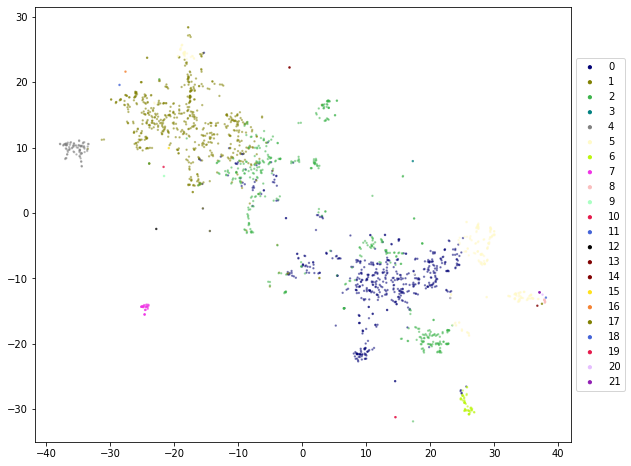

In [128]:
plot_tsne(embedding,classes=louvain_clustering1,
          names=gene_names,legend=True,
          plotting_params={'s':2,'alpha':0.4})

#### Option 2: edges based on cosine similarity,  retaining N best edges (neighbours) for each node

In [129]:
louvain2=LouvainClustering(distance_matrix=distance_matrix, gene_names=gene_names, data=genes_pp, 
                                    orange_graph=False,closest=30)

In [139]:
louvain_clustering2=louvain2.get_clusters_by_genes({'resolution':0.8})

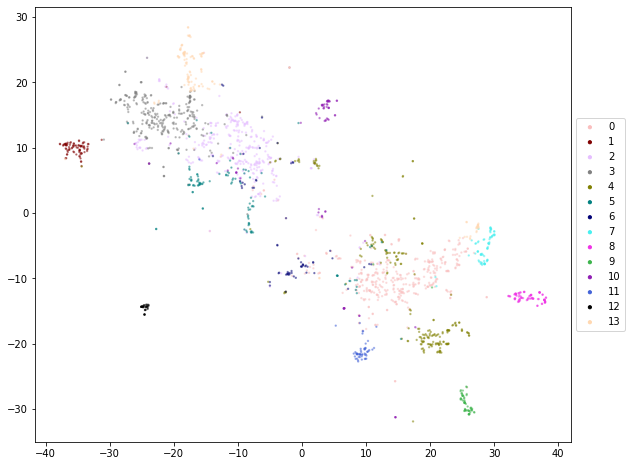

In [140]:
plot_tsne(embedding,classes=louvain_clustering2,
          names=gene_names,legend=True,
          plotting_params={'s':2,'alpha':0.4})

#### Option 3: edges based on Jaccard index

In [159]:
louvain3=LouvainClustering(distance_matrix=distance_matrix, gene_names=gene_names, data=genes_pp, 
                                    orange_graph=True,closest=50)

In [170]:
louvain_clustering3=louvain3.get_clusters_by_genes({'resolution':0.8})

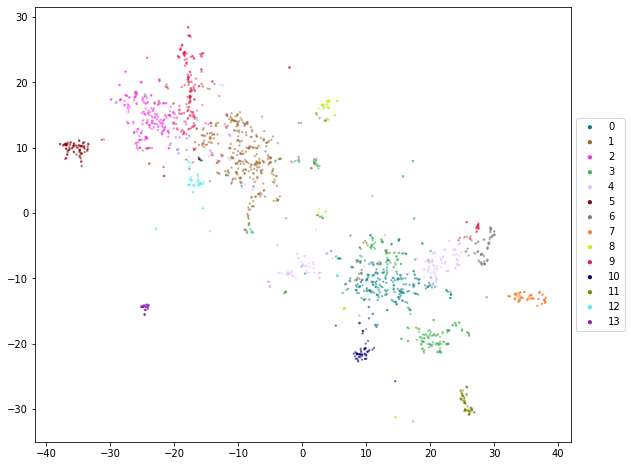

In [172]:
plot_tsne(embedding,classes=louvain_clustering3,
          names=gene_names,legend=True,
          plotting_params={'s':2,'alpha':0.4})

Louvain depends on graph (which can be based on close neighbours) and not whole distance matrix (which is much larger). Thus it can be performed on all genes.

In [180]:
louvain4=LouvainClustering(distance_matrix=None,gene_names=neighbour_calculator._genes.index,
                           data=genes_all_pp,orange_graph=True,closest=60)

In [181]:
louvain_clustering4=louvain4.get_clusters_by_genes({'resolution':1})

In [210]:
from collections import OrderedDict
louvain_clustering4_od=OrderedDict(louvain_clustering4)
clusters_all=pd.DataFrame({'genes':list(louvain_clustering4_od.keys()),'clusters':list(louvain_clustering4_od.values())})
clusters_all.to_csv('clusters_all.tsv',sep='\t',index=False)

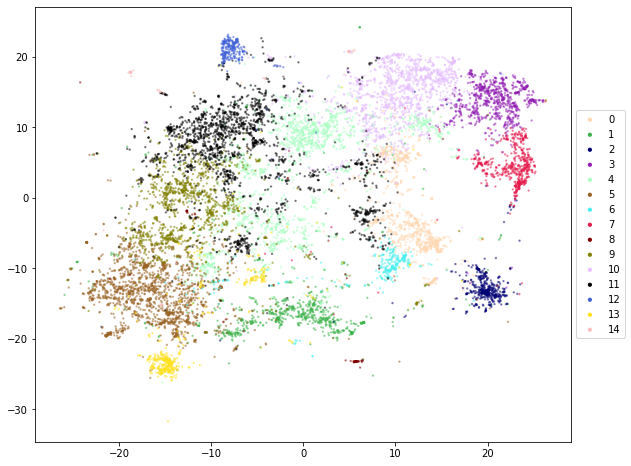

In [201]:
plot_tsne(embedding_all,classes=louvain_clustering4,
          names=neighbour_calculator._genes.index,legend=True,
          plotting_params={'s':2,'alpha':0.4})

This creates clusters somewhat similar to those observed in DE expression heatmap. The below image shows how clusters from Louvain clustering on all genes (as shown above) correspond to clusters from DE expression (below marked as stacks, the DE clustering image is shown above). Most Louvain clusters somewhat overlap with the largest cluster '7' from DE clustering. However, there are also groups that contain predominately genes expressed at the end of differentiation (DE groups 1-5). The clusters that stand out then most in tSNE (2,12,13) have predominately genes from DE clusters 7,6, and 8, respectively. DE clusters 7 and 8 contain genes that aren not DE in mutants compared to AX4 or are expressed before/at the beginning of differentiation. This indicates that they may be important housekeeping genes with coregulated profiles. Indeed, cluster 12 is enriched in cytoskeletal and DNA binding proteins and cluster 13 in transcription/translation related proteins and contains many genes with highly similar expression pattern (e.g. 'selected' genes). Interestingly, cluster 2 contains no 'selected' genes - meaning it has no very tightly coregulated genes. Furthermore, it is comprised almost entirely of hypothetical proteins (412 hypothetical and 23 pseudogenes out of 457 annotated). Thus cluster 2 may be an unexplored pathway, possibly not included in  housekeeping metabolism. 
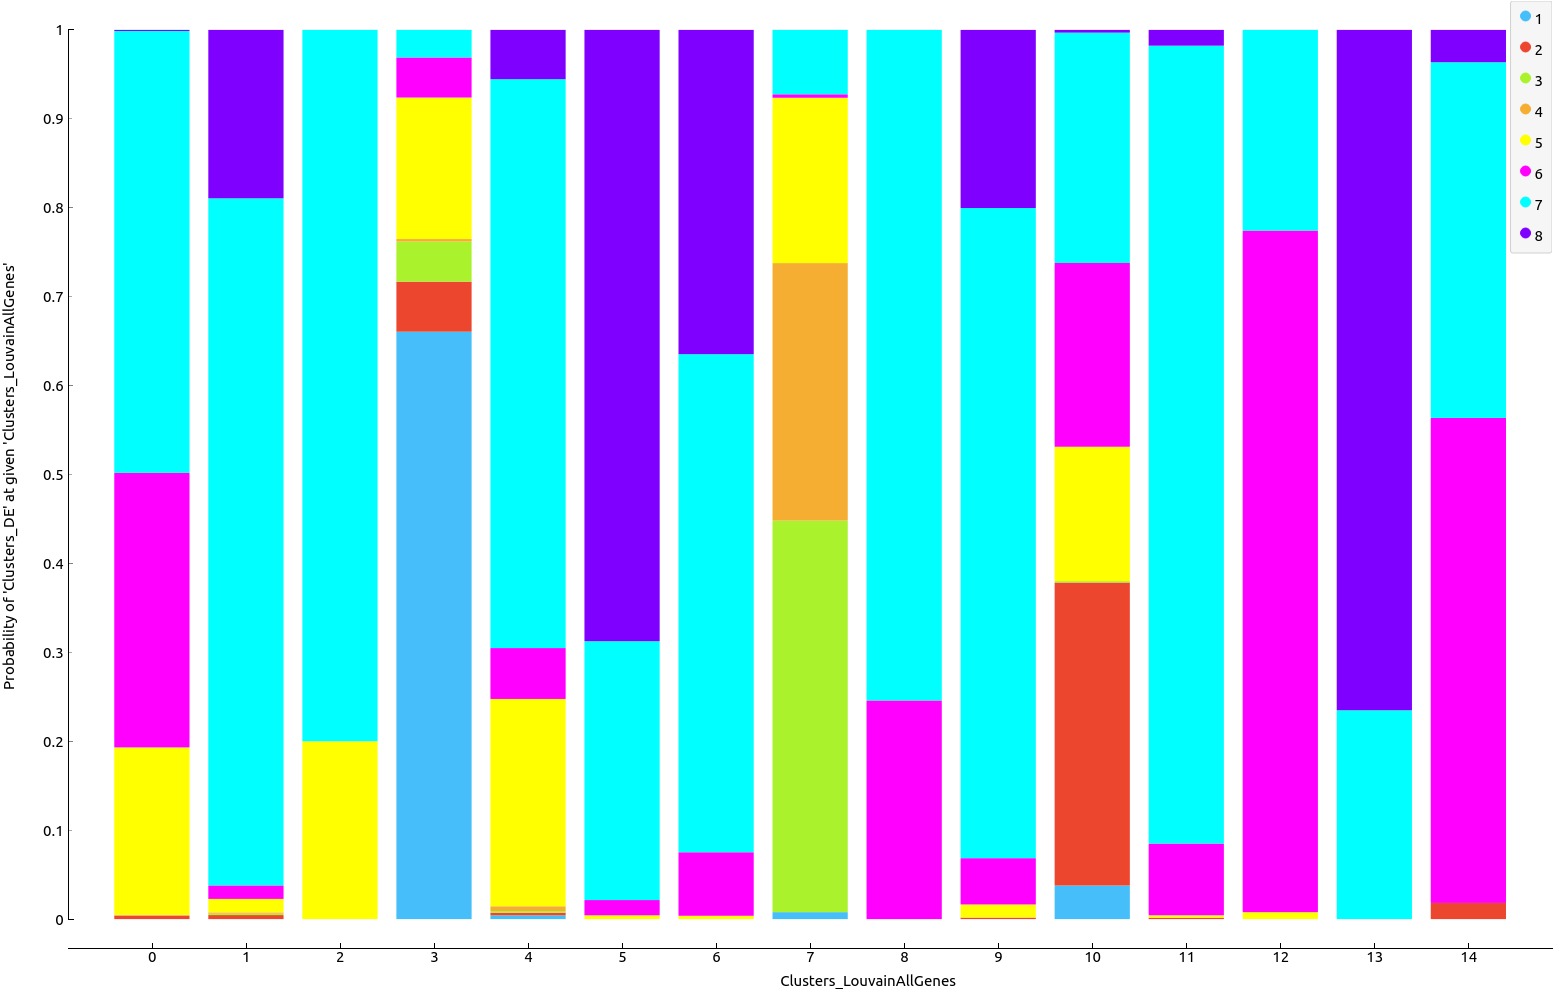

# Conclusion

Based on above results the Louvain clustering (with graph as implemented in Orange) seems to perform the best, as it corresponds well with tSNE. Alternatively, if tSNE is to be followed more strictly I could perform clustering (such as k-means) on tSNE embedding.

As Louvain can be performed on whole gene set there are two options for calculation of regulons: calculation on whole gene set or on gene set comprised of genes with close neighbours. If only very tight associations are seeked, the latter might be better as it would be easier to retrieve potentially small clusters with hight expression pattern similarity. Alternatively, if general patterns are sought all genes can be used. 

For discovery of regulons, as described by Gadi, preselection of tightly corregulated genes would probably be beneficial. For general dicovery of new pathways clustering of all genes would be required (one example would be the cluster 2 in clustering perfomed on  all genes, as discussed above).